# MTG Set Data Analysis for Limited

Import libraries

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

#to print plot below notebook cell:
%matplotlib inline

Quick review of scryfall's and requests api data structure

In [3]:
#Example request
response = requests.get("https://api.scryfall.com/cards/search?q=legal:standard c<=ub")
print(f'Data type: {type(response)}')

#Response dictionary structure
query_response = response.json()
print(f'Json data type: {type(query_response)}')
print(query_response.keys(),'\n')

print(f"query['object']: {type(query_response['object'])}\n\t{query_response['object']}\n")

print(f"query['total_cards']: {type(query_response['total_cards'])}\n\t{query_response['total_cards']}\n")

print(f"query['has_more']: {type(query_response['has_more'])}\n\t{query_response['has_more']}\n")

print(f"query['next_page']: {type(query_response['next_page'])}\n\t{query_response['next_page']}\n")

query_data = query_response['data']
print(f"query['data']: {type(query_data)}")

card_data =  query_data[0]
print(f"\tquery['data'][0]: {type(card_data)}")
print(f"\t\t: {card_data.keys()}")

Data type: <class 'requests.models.Response'>
Json data type: <class 'dict'>
dict_keys(['object', 'total_cards', 'has_more', 'next_page', 'data']) 

query['object']: <class 'str'>
	list

query['total_cards']: <class 'int'>
	924

query['has_more']: <class 'bool'>
	True

query['next_page']: <class 'str'>
	https://api.scryfall.com/cards/search?format=json&include_extras=false&include_multilingual=false&order=name&page=2&q=legal%3Astandard+c%3C%3Dub&unique=cards

query['data']: <class 'list'>
	query['data'][0]: <class 'dict'>
		: dict_keys(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id', 'arena_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang', 'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image', 'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power', 'toughness', 'colors', 'color_identity', 'keywords', 'legalities', 'games', 'reserved', 'foil', 'nonfoil', 'finishes', 'oversized', 'promo', 'reprint', 'variation', 'set_id', 'set', 'set

In [4]:
#card_data structure
with open('./card-example.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(card_data, indent=2, ensure_ascii=False))


Working Class

In [5]:
class ScryfallCardQuery:
    def __init__(self, raw_response):
        self.object = raw_response['object']
        self.total_cards = raw_response['total_cards']
        self.has_more = raw_response['has_more']
        self.raw_data = raw_response['data']
        self.data = pd.DataFrame()

        if self.has_more:
            self.next_page = raw_response['next_page']

        

    def get_dataframe(self, features):
        dict_data = {feature: [card[feature] for card in self.raw_data] for feature in features}
        self.data = pd.concat([self.data, pd.DataFrame(dict_data)], ignore_index=True)

        if self.has_more:
            self.data = pd.concat([self.data, ScryfallCardQuery(requests.get(self.next_page).json()).get_dataframe(features)], ignore_index=True)

        return self.data

Gathering set data with pandas

In [45]:
response = requests.get("https://api.scryfall.com/cards/search?q=set:snc")
snc_query = ScryfallCardQuery(response.json())
features = ['name', 'type_line', 'cmc', 'colors','oracle_text']
snc_data = snc_query.get_dataframe(features)
snc_data

,name,type_line,cmc,colors,oracle_text
0,A Little Chat,Instant,2.0,[U],"Casualty 1 (As you cast this spell, you may sa..."
1,All-Seeing Arbiter,Creature — Avatar,6.0,[U],Flying\nWhenever All-Seeing Arbiter enters the...
2,Angelic Observer,Creature — Angel Advisor,6.0,[W],This spell costs {1} less to cast for each Cit...
3,Angel of Suffering,Creature — Nightmare Angel,5.0,[B],"Flying\nIf damage would be dealt to you, preve..."
4,An Offer You Can't Refuse,Instant,1.0,[U],Counter target noncreature spell. Its controll...
...,...,...,...,...,...
261,Wrecking Crew,Creature — Human Warrior,5.0,[R],"Reach, trample"
262,Xander's Lounge,Land — Island Swamp Mountain,0.0,[],"({T}: Add {U}, {B}, or {R}.)\nXander's Lounge ..."
263,Ziatora's Envoy,Creature — Viashino Warrior,4.0,"[B, G, R]",Trample\nWhenever Ziatora's Envoy deals combat...
264,Ziatora's Proving Ground,Land — Swamp Mountain Forest,0.0,[],"({T}: Add {B}, {R}, or {G}.)\nZiatora's Provin..."


In [46]:
#Dropping Outliers
snc_data.drop(axis=0, index=211, inplace=True)

Type line manual one-hot encoding

In [47]:
def format_colors(row):
    row.colors = str(row.colors).strip('[]').replace("', '",'').replace('\'','')
    if row.colors == '':
        row.colors = 'colorless'
    return row

snc_data = snc_data.apply(format_colors, axis='columns')
snc_data


,name,type_line,cmc,colors,oracle_text
0,A Little Chat,Instant,2.0,U,"Casualty 1 (As you cast this spell, you may sa..."
1,All-Seeing Arbiter,Creature — Avatar,6.0,U,Flying\nWhenever All-Seeing Arbiter enters the...
2,Angelic Observer,Creature — Angel Advisor,6.0,W,This spell costs {1} less to cast for each Cit...
3,Angel of Suffering,Creature — Nightmare Angel,5.0,B,"Flying\nIf damage would be dealt to you, preve..."
4,An Offer You Can't Refuse,Instant,1.0,U,Counter target noncreature spell. Its controll...
...,...,...,...,...,...
261,Wrecking Crew,Creature — Human Warrior,5.0,R,"Reach, trample"
262,Xander's Lounge,Land — Island Swamp Mountain,0.0,colorless,"({T}: Add {U}, {B}, or {R}.)\nXander's Lounge ..."
263,Ziatora's Envoy,Creature — Viashino Warrior,4.0,BGR,Trample\nWhenever Ziatora's Envoy deals combat...
264,Ziatora's Proving Ground,Land — Swamp Mountain Forest,0.0,colorless,"({T}: Add {B}, {R}, or {G}.)\nZiatora's Provin..."


In [48]:
def get_set_card_types(source, ignore=[None]):
    unique_types = []

    
    for line in source:
        candidates = line.split('—')[0].rstrip(' ').split(' ')
        for card_type in candidates:
            if card_type not in unique_types and card_type not in ignore:
                unique_types.append(card_type)
    
    return unique_types
    
supertypes = ['Basic', 'Legendary']
set_unique_types = get_set_card_types(snc_data.type_line, ignore=supertypes)
set_unique_types

# card_type_flags = pd.DataFrame({'is_'+str.lower(type):[type in text for text in snc_data.type_line] for type in set_unique_types})
# len(card_type_flags)
# test_snc_data = pd.concat([snc_data, card_type_flags], axis='columns')
# test_snc_data.tail()

['Instant',
 'Creature',
 'Enchantment',
 'Artifact',
 'Land',
 'Sorcery',
 'Planeswalker']

<AxesSubplot:title={'center':'Streets of New Capenna Card Type Distribution'}>

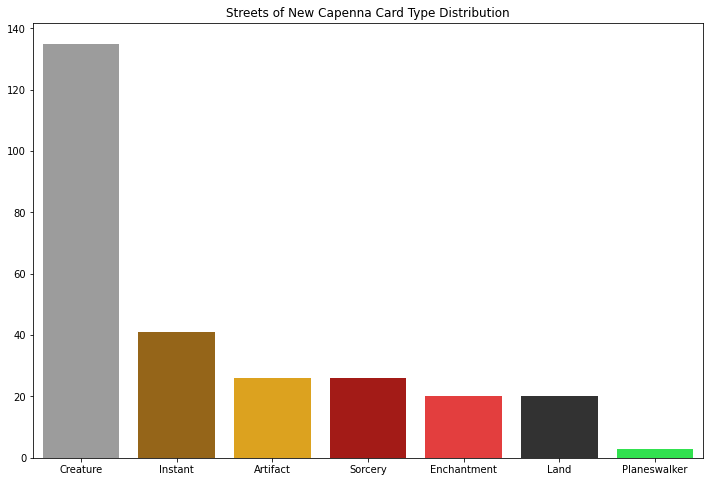

In [49]:
snc_type_distribution = pd.Series(
    {card_type:snc_data[snc_data.type_line.str.contains(card_type)].shape[0] for card_type in set_unique_types}
).sort_values(ascending=False)

plt.figure(figsize=(12,8))
plt.title('Streets of New Capenna Card Type Distribution')
sns.barplot(x=snc_type_distribution.index, y=snc_type_distribution)

Archetype Card Pool Distribution and Curve

In [50]:
def get_cost_distribution(set_data):
    cost_distribution = set_data[set_data.type_line.str.contains('Land').map(lambda b: not b)]
    return cost_distribution

In [51]:
COLORLESS_HEX = '#9C9C9C'
BANT_HEX = '#42BdB0'
NAYA_HEX = '#FFE04D'
GRIXIS_HEX = '#820098'
ESPER_HEX = '#343D72'
JUND_HEX = '#AA6A04'
AZORIUS_HEX = '#5FC7FF'
SELESNYA_HEX = '#90FFAD'
GRUUL_HEX = '#FBAE00'
RAKDOS_HEX = '#BA0500'
DIMIR_HEX = '#080182'
GREEN_HEX = '#13FF3C'
BLUE_HEX = '#1C43D2'
WHITE_HEX ='#EDEDED'
RED_HEX = '#FF2222'
BLACK_HEX  = '#323232'

BROKERS_REGEX_PATTERN = '^[GUW]+$|^colorless$'
BROKERS_COLOR_PATTERN = [COLORLESS_HEX,BANT_HEX,AZORIUS_HEX,SELESNYA_HEX,WHITE_HEX,GREEN_HEX,BLUE_HEX]

CABARETTI_REGEX_PATTERN = '^[GWR]+$|^colorless$'
CABARETTI_COLOR_PATTERN =  [COLORLESS_HEX, NAYA_HEX, SELESNYA_HEX, GRUUL_HEX, WHITE_HEX, GREEN_HEX, RED_HEX]

MAESTROS_REGEX_PATTERN = '^[UBR]+$|^colorless$'
MAESTROS_COLOR_PATTERN = [COLORLESS_HEX, GRIXIS_HEX, RAKDOS_HEX, DIMIR_HEX, BLUE_HEX, BLACK_HEX, RED_HEX]

OBSCURA_REGEX_PATTERN = '^[UWB]+$|^colorless$'
OBSCURA_COLOR_PATTERN = [COLORLESS_HEX, ESPER_HEX, DIMIR_HEX, AZORIUS_HEX, WHITE_HEX, BLACK_HEX, BLUE_HEX]

RIVETEERS_REGEX_PATTERN = '^[GRB]+$|^colorless$'
RIVETTERS_COLOR_PATTERN = [COLORLESS_HEX, JUND_HEX, GRUUL_HEX, RAKDOS_HEX, RED_HEX, BLACK_HEX, GREEN_HEX]

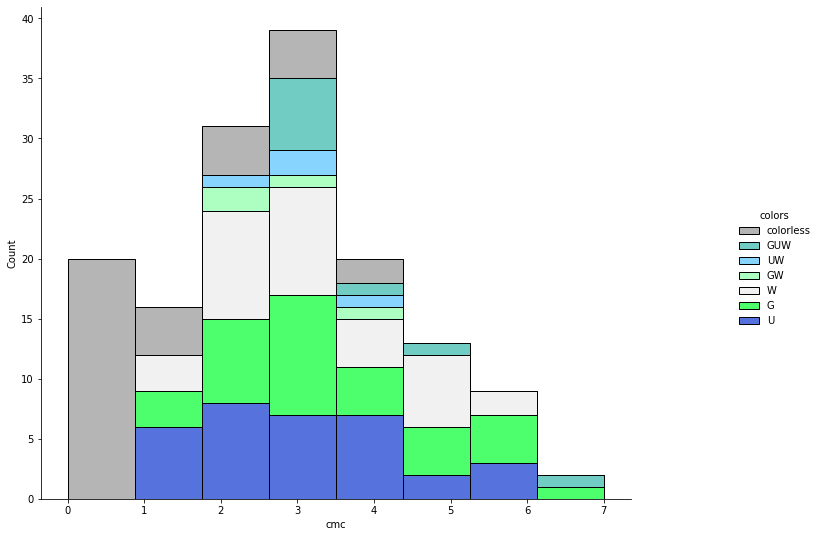

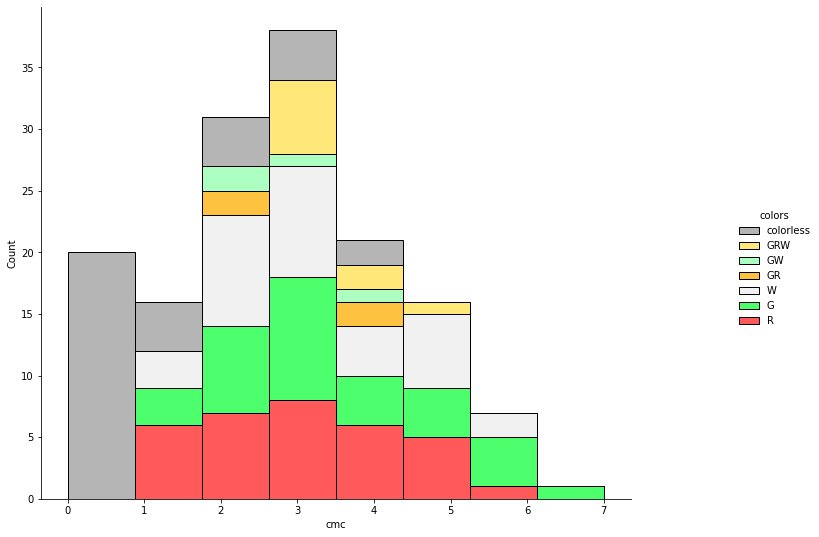

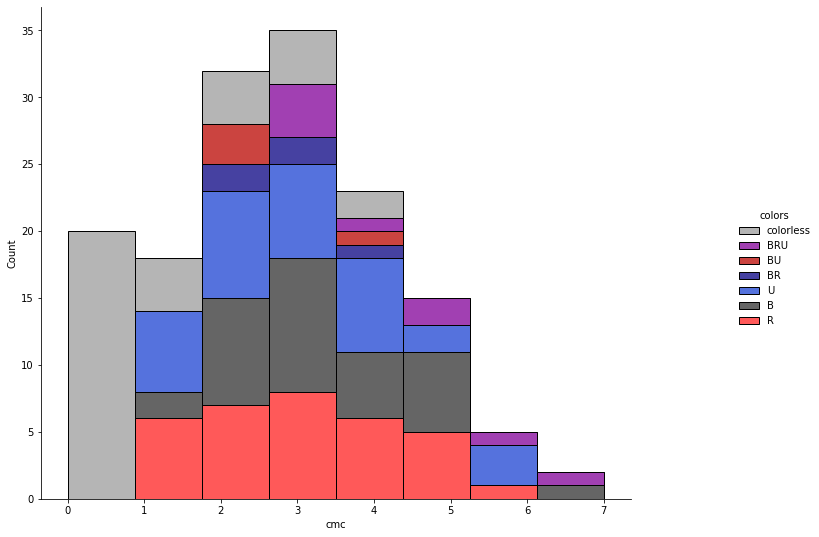

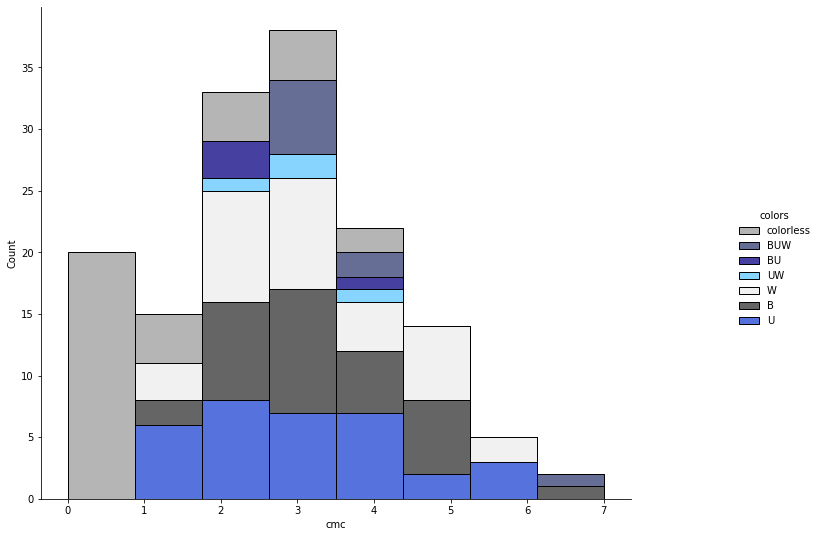

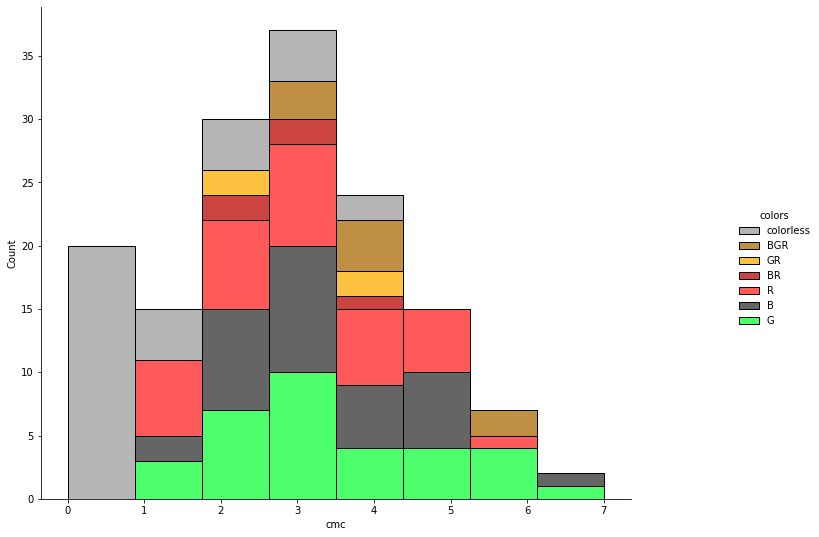

In [52]:
def get_manabase_card_pool_displot(data_source, color_pattern, palette=None):
    target_card_pool = data_source[data_source.colors.str.contains(color_pattern)]
    color_key = target_card_pool.colors.sort_values().str.len().sort_values(ascending=False).index
    sorted_target_card_pool = target_card_pool.reindex(color_key)
    sorted_target_card_pool = sorted_target_card_pool.reset_index(drop=True)
    if palette is not None:
        sns.set_palette(sns.color_palette(palette))
    target_curve_displot = sns.displot(data=sorted_target_card_pool,
            x=sorted_target_card_pool.cmc.astype(int),
            bins=sorted_target_card_pool.cmc.astype(int).max()+1,
            hue='colors',
            multiple='stack')

    target_curve_displot.fig.set_size_inches(12,8)
    return target_curve_displot


brokers_curve_displot = get_manabase_card_pool_displot(snc_data, BROKERS_REGEX_PATTERN, BROKERS_COLOR_PATTERN)
cabaretti_curve_displot = get_manabase_card_pool_displot(snc_data, CABARETTI_REGEX_PATTERN, CABARETTI_COLOR_PATTERN)
maestros_curve_displot = get_manabase_card_pool_displot(snc_data, MAESTROS_REGEX_PATTERN, MAESTROS_COLOR_PATTERN)
obscura_curve_displot = get_manabase_card_pool_displot(snc_data, OBSCURA_REGEX_PATTERN, OBSCURA_COLOR_PATTERN)
riveteers_curve_displot = get_manabase_card_pool_displot(snc_data, RIVETEERS_REGEX_PATTERN, RIVETTERS_COLOR_PATTERN)

